In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [24]:
# Read in CDFS main data
data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(data) # 30,911 galaxies
df = df[df['Use'] == 1] # 13,299 galaxies

In [25]:
c=3.e5  # km/s
h0=70   # km/s/Mpc
dist=df['z']*c/h0  # distance in Mpc

In [28]:
frest = df['FK']
rab = 25 - 2.5*np.log10(frest) # AB magnitude
print(rab)

5745     22.528291
5859     21.775164
5863     22.430403
5879     23.498997
5885     23.709508
           ...    
30860    25.434980
30872    24.093323
30905    25.115062
30907    22.222096
30909    26.083311
Name: FK, Length: 13299, dtype: float64


Text(0, 0.5, 'Number of galaxies')

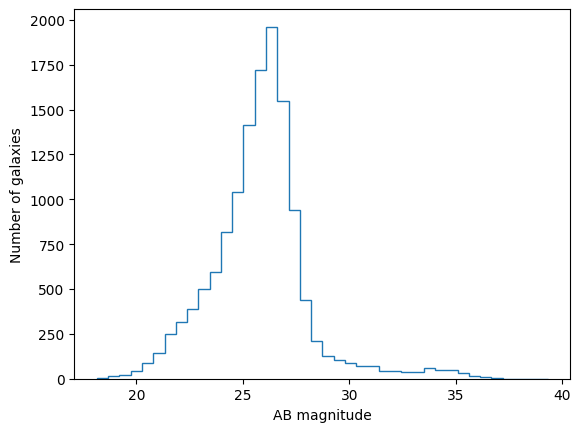

In [35]:
out = plt.hist(rab, bins=40, histtype='step')
# plt.yscale('log')
plt.xlabel('AB magnitude')
plt.ylabel('Number of galaxies')